<a href="https://colab.research.google.com/github/mqc25/Cell_count/blob/master/CellDensityCategory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
Determine Centroid Location

'''


### Imports
%matplotlib inline

import os
import sys
import random
import math
import string
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import imageio

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle


In [0]:
def read_csv_data(full_filename,header=1):
#read in csv data and store in a dictionary

    csv_data=[]

    with open(full_filename) as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        if (header == 1):
            next(csv_reader, None)  # skip the header
        for row in csv_reader:
            #if line_count == 0:
            csv_data.append(np.array(row,dtype=float))
    return csv_data

In [0]:
def get_cross(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nrow,ncol = np.shape(data_in)

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol

    #print(lowrow,highrow,lowcol,highcol)
    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]

    return row_data,col_data


In [0]:
def get_square(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nrow,ncol = np.shape(data_in)

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow -1
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol -1

    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]


    submatrix = data_in[lowrow:highrow,lowcol:highcol]
    return submatrix

In [0]:
def get_centers(input_data,folder_name, number,descriptor):

    box_width = 5 #pixels
    min_threshold = 0.25

    data = np.asmatrix(input_data)
    nr,nc = np.shape(data)
    
    #data = np.asmatrix(csv_data['y_true_120'])
    peak_counter = 0
    peak_points = {}
    for row in range(0,nr):
        peak_points[row]=[]
        for col in range(0,nc):
            if (row >= 0) and (col >=0):
                subm = get_square(data,row,col, box_width) #box around point
                if (data[row,col] >= np.matrix.max(subm)):
                    #remove any points hovering around background values
                    if (data[row,col] > ( (np.matrix.max(data)) * min_threshold)):
                        peak_points[row].append(col)
                        peak_counter = peak_counter + 1
                else:
                    #print(data[row,col], np.max(subm))
                    continue

    plt.imshow(data)
    plt.colorbar()
    for ii in peak_points.keys():
        for jj in peak_points[ii]:
            x=jj
            y=ii
            if (ii == 0):
                mark = 'r.' #use to test special points, if needed
            else:
                mark = 'r.'
            plt.plot(x,y,mark)
    tname = descriptor + '_' + folder_name + '_' + str(keynum) + '_cell count = ' + str(peak_counter) #fname + '_' + 'CellCount= ' + str(peak_counter)
    plt.title(tname)
    plt.show()

    return peak_points

In [42]:
'''
Data directories
'''

use_google_colab = 1 #toggle COLAB setup 
image_type = 2 #0=BCD2, 1 = Aggregate IMG list, 2 = Raw Density Res. Lab imgs
if (use_google_colab == 1):
    ############################################################################
    # Read Data from google drive
    ############################################################################
    from google.colab import drive #for loading gdrive data
    drive.mount('/content/gdrive')

    ###                     MAIN DIRECTORY NAMES
    gdir = '/content/gdrive/My Drive/'
    main_directory = gdir


    if (image_type == 0):
        #main directory for test_prediction_data set
        tp_dir = os.path.join(gdir,'BE224B_2020','Central BCD2')
    elif(image_type == 1):
        #sample data set
        tp_dir = os.path.join(gdir,'BE224B_2020','Density Research Lab 18 samples')

    elif(image_type == 2):
        image_dir = os.path.join(gdir,'BE224B_2020','aggregate_data','imgs')
        csv_dir = os.path.join(gdir,'BE224B_2020','aggregate_data','xy')
        #truth_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','ground_truth')
        #prediction_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','prediction')
    else:
        print('Incorrect Image Type selected')
        sys.exit()

else:
    ############################################################################
    # Read Data from local drive
    ############################################################################
    print('INSERT LOCAL DRIVE INFO')
    sys.exit()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
'''
Get data folders
'''
if (image_type == 0):
    severity_list = os.listdir(tp_dir)

    patient_folder={}
    for sname in severity_list:
        full_path = os.path.join(tp_dir,sname)
        subfolder = os.listdir(full_path)
        print(subfolder)
        patient_folder[sname]=[]
        for ii in subfolder:
            patient_folder[sname].append(ii)
elif(image_type == 1):
    subfolder_list = os.listdir(tp_dir)    
else:
    print('default case')
    subfolder_list = os.listdir(image_dir)


default case


(200, 200, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


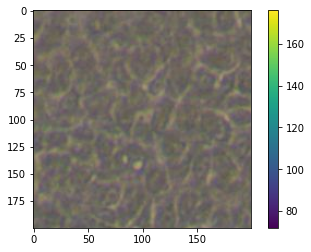

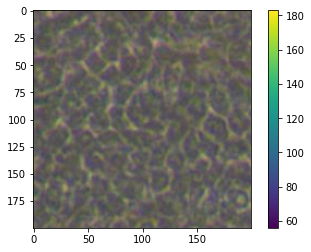

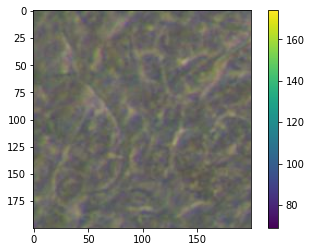

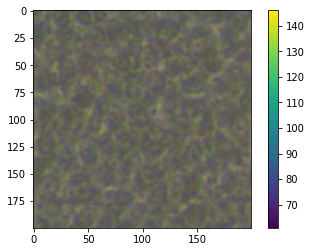

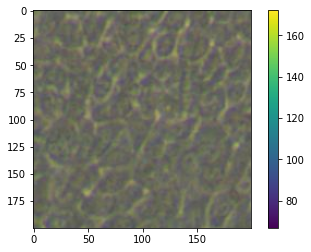

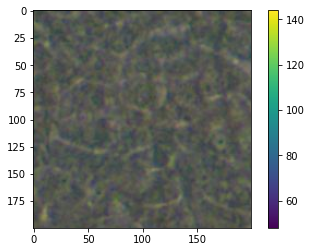

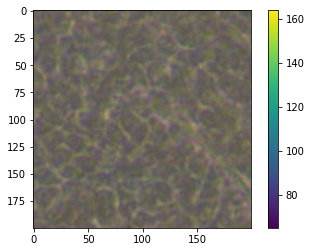

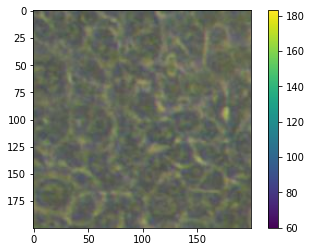

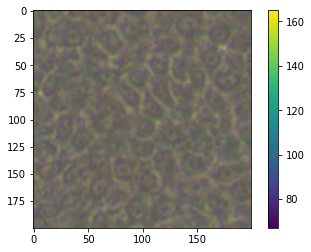

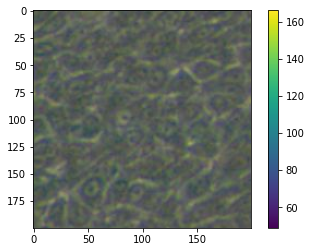

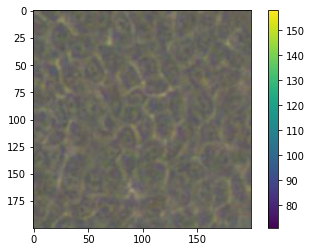

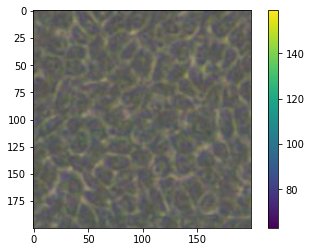

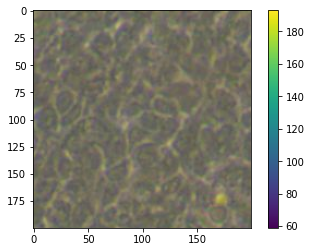

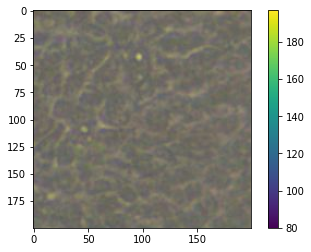

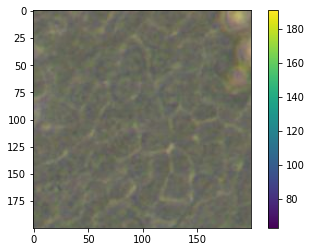

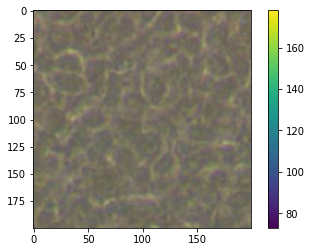

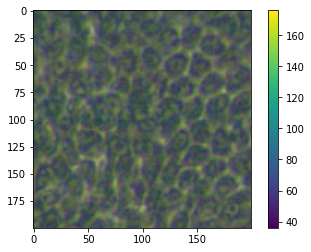

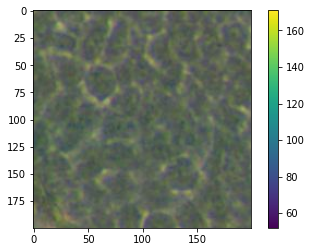

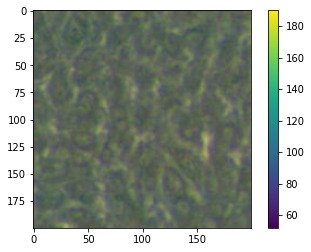

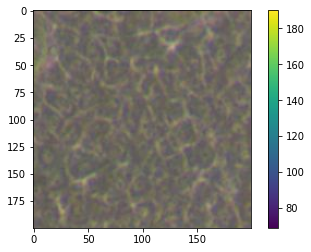

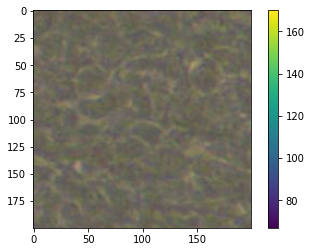

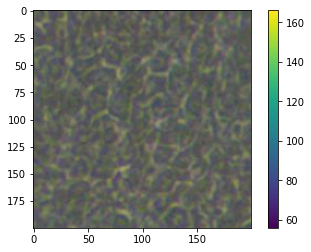

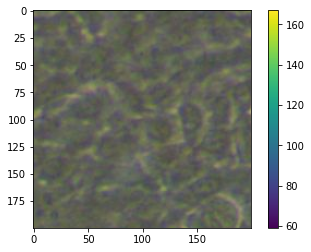

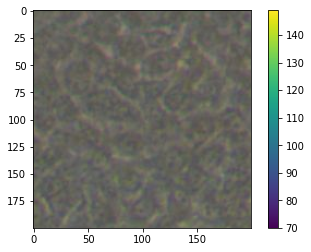

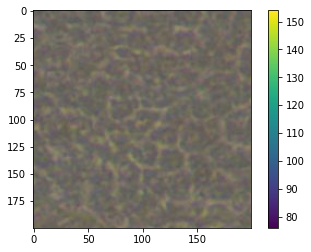

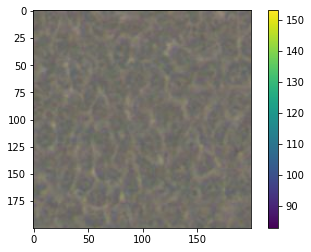

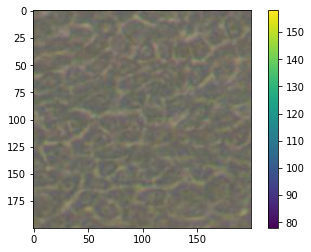

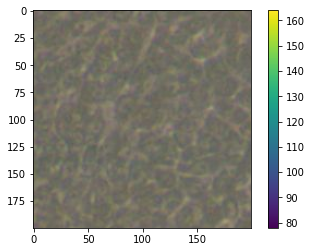

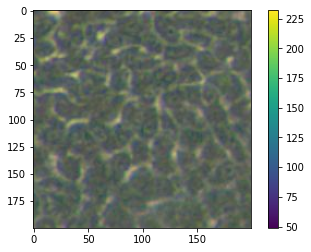

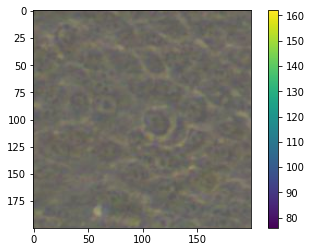

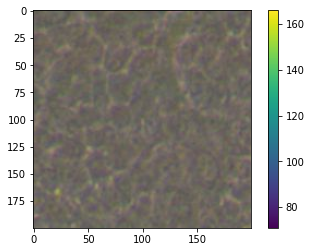

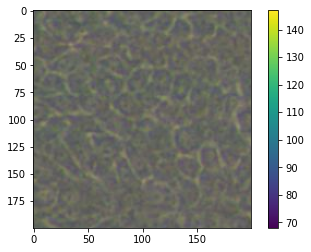

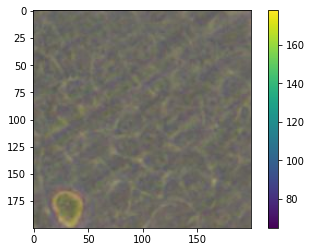

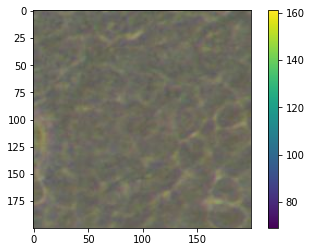

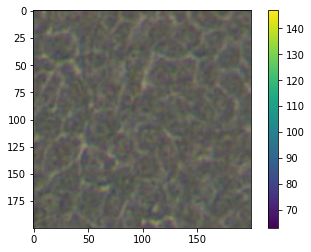

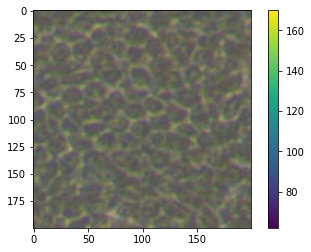

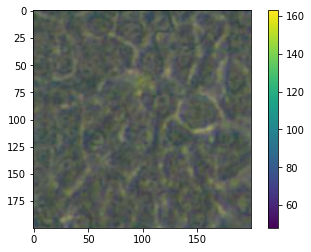

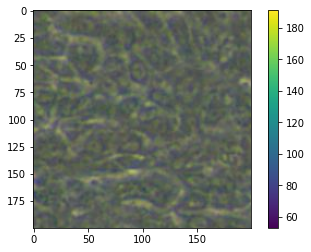

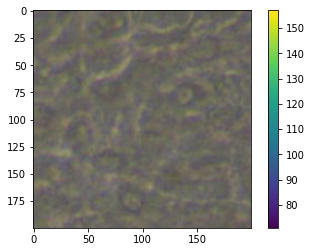

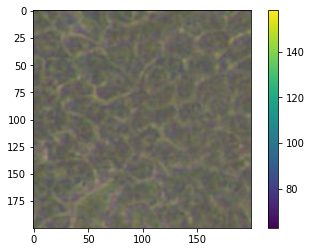

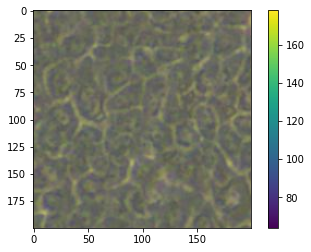

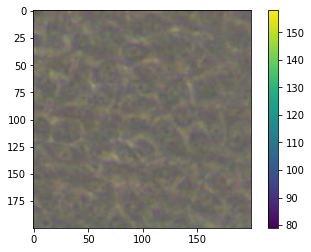

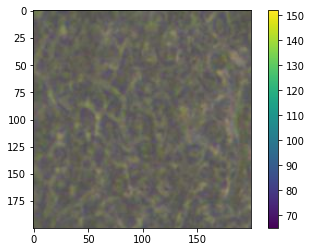

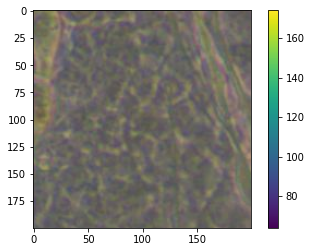

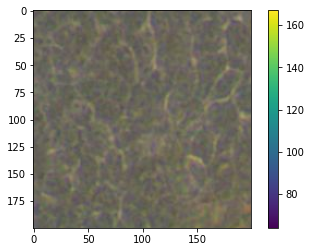

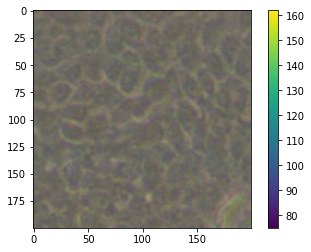

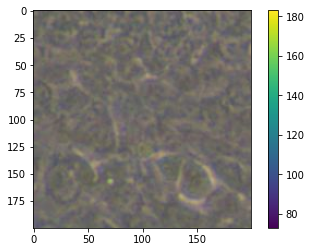

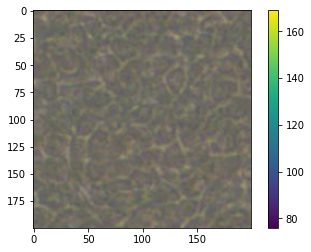

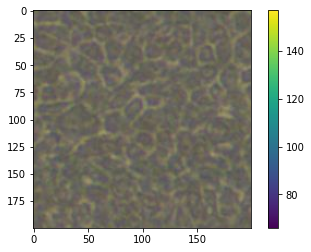

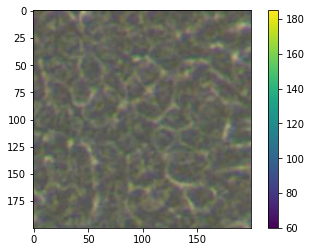

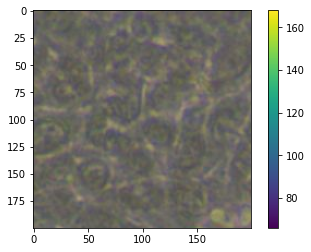

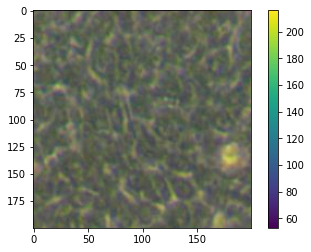

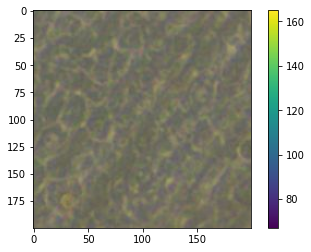

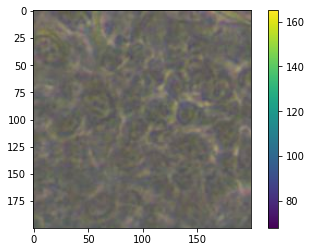

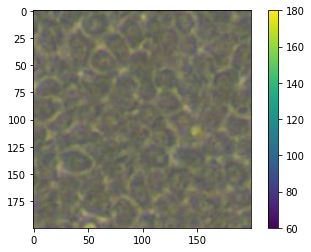

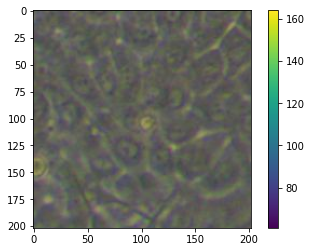

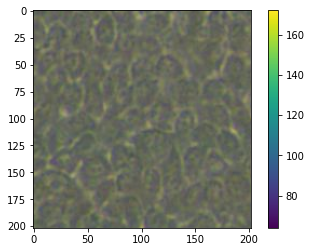

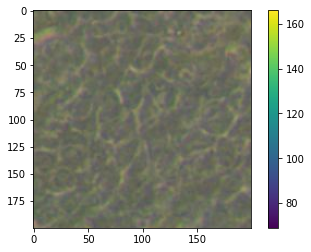

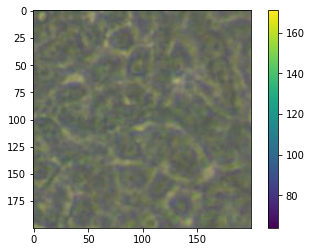

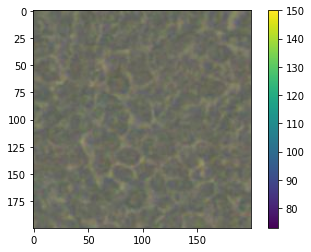

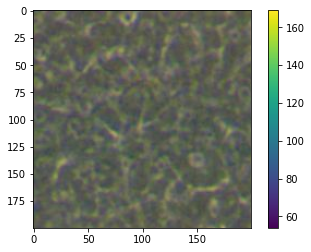

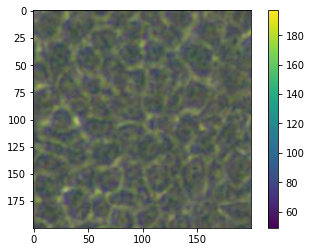

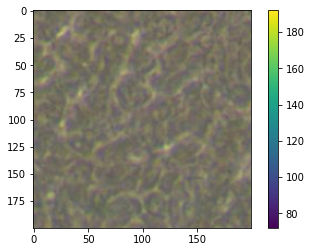

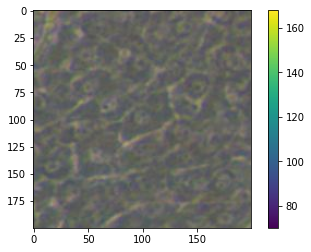

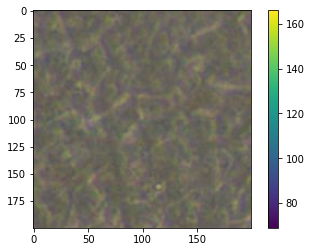

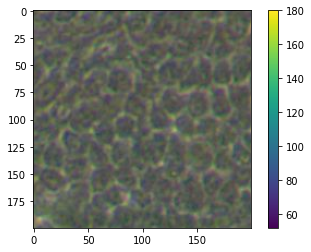

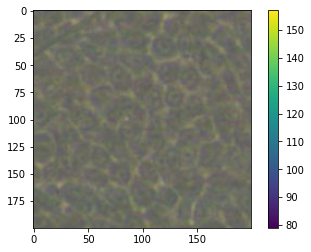

In [47]:
'''
Load the data by severity folders or aggregate folders
'''

if (image_type == 0):

    full_patient_list ={}
    for sname in severity_list:
        folders = patient_folder[sname]
        full_patient_list[sname] ={}

        for folder_name in folders:
            full_patient_list[sname][folder_name] = os.path.join(tp_dir,sname,folder_name)

    #
    # Get file listing
    #
    for sname in full_patient_list.keys():
        print(sname)
        for jj in full_patient_list[sname]:
            print(jj)
            patient_dir = os.path.join(tp_dir,sname,jj)
            file_list = os.listdir(patient_dir)
            print(file_list)

        for fname in file_list:
            full_file = os.path.join(patient_dir, fname)
            print(full_file)
            imdata = imageio.imread(full_file)
            imdata = np.array(imdata)

elif(image_type == 1):
    '''
    Load TIFF images into matrix
    '''
    image_list = os.listdir(image_dir)
    #for every TIFF image, there's a paired CSV file
    csv_list = os.listdir(csv_dir)

    csv_list = [] #store the CSV names
    im = {}
    small_image_list=[]
    for fname in image_list:
        root_ext = os.path.splitext(fname) #will return two parts, name and ext
        filename=root_ext[0]
        #print(root_ext)
        if "dots" not in filename:
            #print('found dots',root_ext[0])
            small_image_list.append(filename)
        else:
            continue
        
        csv_name = filename + '.csv'
        csv_list.append(csv_name)
        imdata = imageio.imread(os.path.join(image_dir,fname))
        im[filename] = np.array(imdata)

    #im = imageio.imread(os.path.join(image_dir,image_list[0]))
    #im = np.array(im)

    print('csv file 0  is  ',csv_list[0])
    print('dots image 0 is ', small_image_list[0])
    #csv_file = os.path.join(csv_dir,csv_list[0])
    csv_data ={}

    plt.figure()
    plt.imshow(im[small_image_list[0]])
    plt.title(str(image_list[0]))

else:
    #use aggregated folder, which has all images in one folder
    patient_folder = image_dir
    small_image_list =[]
    file_list = os.listdir(image_dir)

    im={}

    for filename in file_list:
        if "dots" not in filename:
            #print('found dots',root_ext[0])
            small_image_list.append(filename)

            imdata = imageio.imread(os.path.join(image_dir,filename))
            im[filename] = np.array(imdata)
        else:
            continue
        



for counter,ii in enumerate(im.keys()):
    if (counter == 0):
        print(np.shape(im[ii]))
    plt.figure()
    plt.imshow(im[ii])
    plt.colorbar()
    #get_square(im, row, col,dlength):

    #im = imageio.imread('filename')
    #im = np.array(im)

In [62]:
np.shape(im['D1_R1_day_9_Image1.tif'])

(200, 200, 3)

(200, 200)


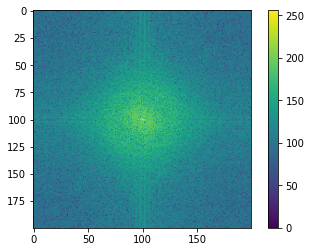

In [109]:
plt.figure()
a=im['D1_R1_day_9_Image1.tif'][:,:,2]
#a=im['D1_R4_day_9_Image6.tif'][0][:,:,2]
print(np.shape(a))

f = np.fft.fft2(a)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.imshow(magnitude_spectrum,vmin=0, vmax = 256)
plt.colorbar()

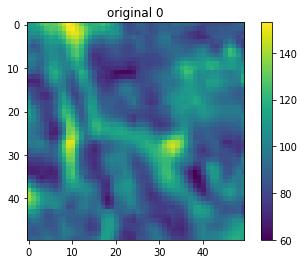

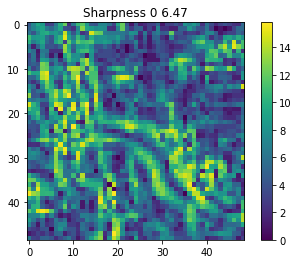

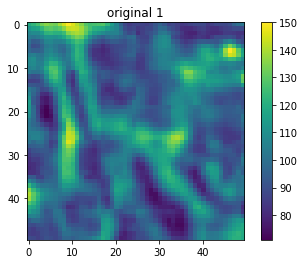

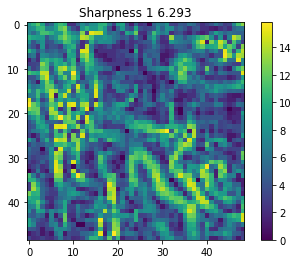

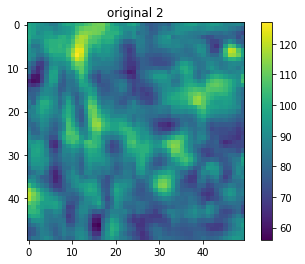

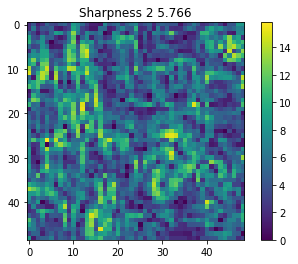

In [113]:
'''
Get Sharpness estimates per channel for a square
'''
for ii in range(0,3):
    b=im['D1_R1_day_9_Image1.tif'][:,:,ii]

    a = get_square(b, 100, 100,25)

    dx = np.diff(a)[1:,:] # remove the first row
    dy = np.diff(a, axis=0)[:,1:] # remove the first column
    dnorm = np.sqrt(dx**2 + dy**2)
    sharpness = np.average(dnorm)

    '''
    plt.figure()
    plt.imshow(dx)
    plt.colorbar()

    plt.figure()
    plt.imshow(dy)
    plt.colorbar()
    '''

    b=dnorm[0,0]
    type(b)
    float(b)
    isinstance(float(b),float)

    plt.figure()
    plt.imshow(a)
    plt.colorbar()
    stext = 'original ' + str(ii)
    plt.title(stext)


    b=dnorm.astype(float)
    plt.figure()
    plt.imshow(b)
    plt.colorbar()
    stext = 'Sharpness ' + str(ii) + ' ' + str(sharpness)
    plt.title(stext)

